# Extraction of features

In this script, we will extract effort-related features from the merged multimodal trial data. 

Because we are dealing with time-varying data, we will extract number of statistics that characterize both instantaneous as well as cumulative nature of each (acoustic, motion, postural) timeseries. To investigate the relation of multimodal synchrony and corrections, we will compute the synchronization between the modalities in trials with combined modalities (ie. multimodal), computed as the time between acceleration peak (thought as a proxy of stroke) and peak in f0/env.

Before we collect all relevant features, we normalize all time-varying features in the trial by minimum and maximum observed values for that feature for a participant. This is because we want to account for individual differences/strategies in using the whole range of motion and/or acoustic features. We therefore treat effort as a relative measure but because we cannot access information about the minimum/maximum possible by a participant, we take the maximum and minimum that were observed within the whole experiment.

In [1]:
# Import packages

import os
import glob
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import antropy as ent
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
import seaborn as sns
import builtins


curfolder = os.getcwd()

# Here we store our merged final timeseries data
mergedfolder = curfolder + "\\..\\05_finalMerge\\TS_final\\"
filestotrack = glob.glob(mergedfolder + "merged_anno*.csv")

# Here we store concept similarity data
conceptsimfolder = curfolder + "\\..\\06_ConceptSimilarity\\data\\"

# Here we store other potentially useful data
metadatafolder = curfolder + "\\..\\00_RAWDATA\\"

# Here we store the final data
datafolder = curfolder + "\\Datasets\\"

# We are interested only in data from part 2, and only those that are not practice trials
files_part2 = []

# These are practice trials
practicetrials = ['0_2_0', '0_2_1', '0_2_19', '0_2_20', '0_2_21', '0_2_22', '0_2_38', '0_2_39', '0_2_40', '0_2_53', '0_2_54', '0_2_55', '0_2_56', '0_2_67', '0_2_68', '0_2_69', '0_2_70', '0_2_71', '0_2_72', '0_2_92', '0_2_93', '0_2_94', '0_2_95', '0_2_96', '0_2_97']

# Collect to list only files that are in part 2 and are not practice trials
for file in filestotrack:
    exp_part = file.split("\\")[-1].split("_")[3]
    if exp_part == "2":
        if not any([x in file for x in practicetrials]):
            files_part2.append(file)



## Prepare extra metadata

To get additional metadata about the trials, we also need to load in and pre-process some more data, such as:

- Similarity between answer and a target concept (see XXX). This dataframe has information about the similarity between an answer and performed target concept, computed as cosine similarity of embeddings retrieved from ConceptNet

- Expressibility of a concept (XXX). This dataframe has information about expressibility of each concept in a stimuli list. The ratings were acquired from a separate group of people that participated in an online study (see XXX).

- Response time. This dataframe has information about how long it took a guesser to provide an answer to a performance, measured from the end of the performance until pressing an Enter to confirm the answer.

In [2]:
# Load in similarity from ConceptNet
similarityfile = conceptsimfolder + "df_final_conceptnet.csv"
similaritydata = pd.read_csv(similarityfile)

# Keep only rows where exp = 2
similaritydata = similaritydata[similaritydata['exp'] == 2]
similaritydata = similaritydata.reset_index(drop=True)

# In similarity data, create index column that tracks the row number
similaritydata['index'] = similaritydata.index

# In practicetrials list, for each element, keep only the last element separated by "_"
practicetrials2 = [x.split("_")[-1] for x in practicetrials]

# Convert the list to integers
practicetrials2 = [int(x) for x in practicetrials2]

# Keep only those rows that have index that is NOT in the practicetrials2 list
similaritydata = similaritydata[similaritydata['index'].apply(lambda x: x not in practicetrials2)]

# We don't need exp col anymore
similaritydata = similaritydata.drop(columns=['exp'])

similaritydata.head(15)

,word,answer,English,answer_en,cosine_similarity,mean_similarity,index
2,vrouw,zwanger,female,pregnant,0.265491,4.3,2
3,vrouw,haar,female,hair,0.235659,2.7,3
4,vrouw,douchen,female,to shower,0.025075,0.5,4
5,verbranden,pijn,to burn,pain,0.118826,4.4,5
6,verbranden,verbrand,to burn,burnt,0.883181,8.5,6
7,verbranden,heet,to burn,hot,0.411851,6.8,7
8,ik,ik,I,I,1.000000,10.0,8
9,kauwen,kauwen,to chew,to chew,1.000000,10.0,9
10,vliegen,vogel,to fly,bird,0.433074,5.9,10
11,vliegen,vliegtuig,to fly,airplane,0.744683,6.4,11


In [3]:
# Load in expressibility for Dutch
express_nl = metadatafolder + "expressibility_nl.csv"
express_df = pd.read_csv(express_nl)

# Rename modalities to Dutch to match it with the rest of the data
express_df['modality'] = express_df['modality'].replace(['gesture', 'multimodal', 'vocal'], ['gebaren', 'combinatie', 'geluiden'])

# Leave only word, modality and fit
express_df = express_df[['word', 'modality', 'fit']]

# Round fit
express_df['fit'] = express_df['fit'].round(3)

express_df.head(15)

,word,modality,fit
0,aanraken,gebaren,0.671
1,aanraken,combinatie,0.695
2,aanraken,geluiden,0.207
3,aarde,gebaren,0.539
4,aarde,combinatie,0.524
5,aarde,geluiden,0.195
6,ademen,gebaren,0.782
7,ademen,combinatie,0.808
8,ademen,geluiden,0.785
9,alles,gebaren,0.351


In [4]:
# In metadatafolder, find all csv files that might be in the folders in the metadatafolder
answerfiles = glob.glob(metadatafolder + "\\*\\*results.csv")

# Keep only those that have as second element in the filename "2"
answerfiles = [x for x in answerfiles if x.split("\\")[-1].split("_")[1] == "2"]

# Load all in df
answerdata = pd.concat([pd.read_csv(x) for x in answerfiles])

# add column index that tracks the row number
answerdata['index'] = answerdata.index

# keep only those rows that have index that is NOT in the practicetrials2 list
answerdata = answerdata[answerdata['index'].apply(lambda x: x not in practicetrials2)]

# create column TrialID that will consists of 0_2_ + the index + 'p'+cycle
answerdata['TrialID'] = '0_2_' + answerdata['index'].astype(str) + '_p' + answerdata['cycle'].astype(str)

# create colum response_time_sec that is RT - trial_end
answerdata['response_time_sec'] = answerdata['RT'] - answerdata['trial_end']

# now keep only TrialID and response_time_sec
answerdata = answerdata[['TrialID', 'response_time_sec']]

answerdata.head(15)

,TrialID,response_time_sec
2,0_2_2_p0,5.112085
3,0_2_3_p0,14.575548
4,0_2_4_p0,4.007712
5,0_2_5_p0,3.792969
6,0_2_6_p0,6.091050
7,0_2_7_p0,3.719071
8,0_2_8_p0,6.466305
9,0_2_9_p0,5.328248
10,0_2_10_p0,2.726925
11,0_2_11_p0,2.911562


## Extracting features: rationale

In the following part, we will be extracting summaries from the existing timeseries that we pre-processed in the previous scripts. The goal is to capture the effort-related features that might be relevant in a repair, i.e., when a participant has to correct themselves to regain understanding with their partner who previously did not understand the performed concept.

Because we are dealing with time-varying data, we will extract number of statistics that characterize both instantaneous as well as cumulative nature of each (acoustic, motion, postural) timeseries. These are:

- global mean and standard deviation
- number, mean and standard deviation of the peaks (using function `find_peaks` from `scipy.signal`)
- range of the values
- integral of selected timeseries
- xxx

Additionally, we will compute sample entropy to measure the complexity of a timeseries.

Furthermore, we will utilize measurements that capture characteristics beyond the statistics sketched above. These include:

- intermittency (as a dimensionless jerk, used in REF)
- bounding box of movement volume (i.e., gesture space, used in REF)
- VSA (i.e., vocal space area, used in REF)
- motor complexity (computed as the slope of PCA; used in REF)
- number of submovements (used in REF)
- number of moving articulators
- xxxx

Before proceeding to the feature extraction for all trials, we will first demonstrate the features on a single trial.

In [10]:
# HERE SHOW THE VIDEO OF A SINGLE TRIAL

# Load the sample
sample = files_part2[13]
df = pd.read_csv(sample)
df.head(15)

,time,left_back,right_forward,right_back,left_forward,COPXc,COPYc,COPc,TrialID,FileInfo,...,lowerbody_power,leg_power,head_power,arm_power,vocalization,head_mov,upper_mov,lower_mov,arms_mov,movement_in_trial
0,0.0,1.091414,0.812872,1.478586,1.402141,-0.000081,-0.000123,0.000147,0_2_35_p1,p1_heet_combinatie_c0,...,144.037973,30.392866,6.598872,20.666987,silent,nomovement,nomovement,nomovement,nomovement,nomovement
1,2.0,1.091428,0.812730,1.478577,1.402041,-0.000026,-0.000143,0.000145,0_2_35_p1,p1_heet_combinatie_c0,...,143.013637,30.064849,6.588030,20.485553,silent,nomovement,nomovement,nomovement,nomovement,nomovement
2,4.0,1.091438,0.812628,1.478587,1.401950,0.000022,-0.000152,0.000153,0_2_35_p1,p1_heet_combinatie_c0,...,141.829413,29.700122,6.576142,20.287540,silent,nomovement,nomovement,nomovement,nomovement,nomovement
3,6.0,1.091445,0.812564,1.478619,1.401872,0.000062,-0.000151,0.000163,0_2_35_p1,p1_heet_combinatie_c0,...,140.503037,29.303808,6.563400,20.075776,silent,nomovement,nomovement,nomovement,nomovement,nomovement
4,8.0,1.091455,0.812539,1.478673,1.401814,0.000094,-0.000142,0.000170,0_2_35_p1,p1_heet_combinatie_c0,...,139.052245,28.881032,6.550000,19.853090,silent,nomovement,nomovement,nomovement,nomovement,nomovement
5,10.0,1.091469,0.812549,1.478751,1.401778,0.000121,-0.000126,0.000175,0_2_35_p1,p1_heet_combinatie_c0,...,137.494773,28.436917,6.536134,19.622309,silent,nomovement,nomovement,nomovement,nomovement,nomovement
6,12.0,1.091489,0.812593,1.478853,1.401769,0.000141,-0.000107,0.000177,0_2_35_p1,p1_heet_combinatie_c0,...,135.848356,27.976589,6.521996,19.386264,silent,nomovement,nomovement,nomovement,nomovement,nomovement
7,14.0,1.091519,0.812669,1.478979,1.401789,0.000156,-0.000083,0.000177,0_2_35_p1,p1_heet_combinatie_c0,...,134.130731,27.505171,6.507781,19.147780,silent,nomovement,nomovement,nomovement,nomovement,nomovement
8,16.0,1.091559,0.812777,1.479131,1.401840,0.000166,-0.000058,0.000176,0_2_35_p1,p1_heet_combinatie_c0,...,132.390932,27.037479,6.494090,18.915396,silent,nomovement,nomovement,nomovement,nomovement,nomovement
9,18.0,1.091613,0.812914,1.479307,1.401923,0.000172,-0.000031,0.000175,0_2_35_p1,p1_heet_combinatie_c0,...,130.608308,26.567368,6.480689,18.685650,silent,nomovement,nomovement,nomovement,nomovement,nomovement


### Basic statistics

Basic statistics capture properties of the timeseries in several dimensions:
- globally (mean, standard deviation of the timeseries, range of the values, rate of the feature)
- locally (number, mean and standard deviation of the peaks)
- cummulatively (integral of the timeseries)
- complexity (sample entropy)

We also collect the time stamps of the peaks, as we will use them to compute the synchronization between the modalities.

In [11]:
# Function to calculate stats for a feature
def get_statistics(cols, df, subdf, dictionary, duration):
    for col in cols:
        Gmean = subdf[col].mean()   # General mean
        Gstd = subdf[col].std()     # General std
        peaks, _ = find_peaks(subdf[col], height=subdf[col].mean(), distance=200)
        peaks_values = df.loc[peaks, col] # Peak values
        peaks_times = df.loc[peaks, "time"].tolist() # Peak time

        peak_mean = peaks_values.mean() # Peak mean
        peak_std = peaks_values.std()   # Peak std
        peak_n = len(peaks_values)      # Number of peaks

        ts = subdf[col]
        sampen = ent.sample_entropy(ts, order=2) # Sample entropy

        integral = np.trapz(subdf[col]) # Integral
        range = subdf[col].max() - subdf[col].min() # Range
        rate = Gmean / duration         # Rate
        
        # Save all in dictionary
        dictionary[col] = [Gmean, Gstd, peak_mean, peak_std, peak_n, peaks_times, integral, sampen, range, rate]

    return dictionary

subdf = df[df["movement_in_trial"] == "movement"]
sample_dict = {}
sample_col = ['RWrist_speed']
sample_duration = subdf["time"].max()
if subdf.shape[0] > 0:
    sample_dict = get_statistics(sample_col, df, subdf, sample_dict, sample_duration)

# Convert dictionary to dataframe
sample_features = pd.DataFrame({key: [value] for key, value in sample_dict.items()})

# Function to adapt row
def adapt_row(row_to_process):
    for col in row_to_process.columns:
        # Calculate for all expcet some already calculated measures
        if 'inter' not in col and 'sampEn' not in col and 'bbmv' not in col and 'duration' not in col:
            row_to_process[col + '_Gmean'] = row_to_process[col].apply(lambda x: x[0])
            row_to_process[col + '_Gstd'] = row_to_process[col].apply(lambda x: x[1])
            row_to_process[col + '_peak_mean'] = row_to_process[col].apply(lambda x: x[2])
            row_to_process[col + '_peak_std'] = row_to_process[col].apply(lambda x: x[3])
            row_to_process[col + '_peak_n'] = row_to_process[col].apply(lambda x: x[4])
            row_to_process[col + '_peak_times'] = row_to_process[col].apply(lambda x: x[5])
            row_to_process[col + '_integral'] = row_to_process[col].apply(lambda x: x[6])
            row_to_process[col + '_sampen'] = row_to_process[col].apply(lambda x: x[7])
            row_to_process[col + '_range'] = row_to_process[col].apply(lambda x: x[8])
            row_to_process[col + '_rate'] = row_to_process[col].apply(lambda x: x[9])

    # Now keep only this newly created cols
    row_final = row_to_process[[col for col in row_to_process.columns if any(x in col for x in ['Gmean', 'Gstd', 'peak_mean', 'peak_std', 'peak_n', 'sampen', 'inter', 'sampEn', 'integral', 'peak_times', 'bbmv', 'rate', 'range', 'duration'])]]
    
    return row_final

# Adapt the row
sample_features = adapt_row(sample_features)

# Here we see the results
sample_features.head()

,RWrist_speed_Gmean,RWrist_speed_Gstd,RWrist_speed_peak_mean,RWrist_speed_peak_std,RWrist_speed_peak_n,RWrist_speed_peak_times,RWrist_speed_integral,RWrist_speed_sampen,RWrist_speed_range,RWrist_speed_rate
0,46.280097,23.403965,43.136272,39.139608,3,"[534.0, 1284.0, 1816.0]",91424.562166,0.026322,93.802252,0.009103


### Bouding box of movement volume

Bounding box of movement volume (BBMV) is a measure of the space covered by the participant's gestures (see REF-Premek). It is computed as the difference between the maximum and minimum values of the timeseries.

In [24]:
# Function to calcuate bounding box of movement volume (from REF-Premek)       
def get_bbmv(df, group, kp_dict):
    coordinates = [col for col in df.columns if any(x in col for x in ['_x', '_y', '_z'])]

    # Prepare columns that belong to a group (e.g., arm)
    kp = kp_dict[group]
    colstoBBMV = [col for col in coordinates if any(x in col for x in kp)]

    # Keep only unique names without coordinates
    kincols = list(set([col.split('_')[0] for col in colstoBBMV]))

    bbmvs = {}
    for col in kincols:
        # Span of x, y, z
        x_span = df[col + '_x'].max() - df[col + '_x'].min()
        y_span = df[col + '_y'].max() - df[col + '_y'].min()
        z_span = df[col + '_z'].max() - df[col + '_z'].min()

        # Calculate BBMV
        bbmv = x_span * y_span * z_span
        bbmvs[col] = bbmv
        
    # Get the sum for the whole group
    bbmv_sum = sum(bbmvs.values())

    # Natural logarithm
    bbmv_sum = np.log(bbmv_sum)

    return bbmv_sum

# Calculate on sample
# These are groups for BBMV
kp_arms = ['RWrist', 'RElbow', 'RShoulder', 'LWrist', 'LElbow', 'LShoulder']
kp_lower = ['RAnkle', 'RKnee', 'LAnkle', 'LKnee']
kp_legs = ['RAnkle', 'RKnee', 'LAnkle', 'LKnee']
kp_head = ['Head']
kp_keys = {'arm': kp_arms, 'lowerbody': kp_lower, 'leg': kp_legs, 'head': kp_head}
subdf = df[df["movement_in_trial"] == "movement"]

# Calculate BBMV for sample
bbmv = get_bbmv(subdf, 'arm', kp_keys)
print(bbmv)

11.34170186008011


### Intermittency

will fill in

In [25]:
# Function to calculate intermittency (from REF-Wim)
def get_intermittency(jerk_values, speed_values):
    """Calculate the dimensionless smoothness measure using precomputed smoothed jerk and speed."""
    smoothed_jerk = jerk_values
    speed = speed_values
    
    if not np.all(speed == 0):
        integrated_squared_jerk = np.sum(smoothed_jerk ** 2)
        max_squared_speed = np.max(speed ** 2)
        D3 = len(speed) ** 3
        jerk_dimensionless = integrated_squared_jerk * (D3 / max_squared_speed)
        smoothness = jerk_dimensionless
    else:
        smoothness = np.nan

    return smoothness

# Calculate on sample
subdf = df[df["arms_mov"] == "movement"]
group = 'arm'

# Get the columns that contain group and sum/power (these are cols with aggregated measures)
cols = [col for col in subdf.columns if group in col and 'sum' in col or 'power' in col]

# Calculate intermittency for kinematic measures (from Pose2sim)
speed = subdf[group + "_speedKin_sum"].values
jerk = subdf[group + "_jerkKin_sum"].values
intermittency_kin = get_intermittency(jerk, speed)
intermittency_kin = np.log(intermittency_kin) # natural log
print(intermittency_kin)

# Calculate intermittency for inverse kinematic measures (from OpenSim)
speed = subdf[group + "_angSpeed_sum"].values
jerk = subdf[group + "_angJerk_sum"].values
intermittency_ik = get_intermittency(jerk, speed)
intermittency_ik = np.log(intermittency_ik) # natural log
print(intermittency_ik)


17.99700406841202
19.262020887470193


### Vocal space area


will fill in

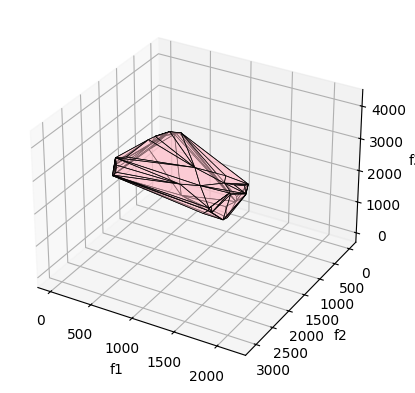

In [26]:
# Function to calculate vocal space area (as a convex hull), REF
def getVSA(df, plot=False):
    f1_clean = df['f1_clean'].dropna()
    f2_clean = df['f2_clean'].dropna()
    f3_clean = df['f3_clean'].dropna()
    
    # 2d convex hull
    points = np.array([f1_clean, f2_clean]).T
    hull_2d = ConvexHull(points)
    volume_2d = hull_2d.volume
    volume_2d = np.log(volume_2d) # natural log

    # 3d convex hull
    points = np.array([f1_clean, f2_clean, f3_clean]).T
    hull_3d = ConvexHull(points) # get the volume of the convex hull
    volume_3d = hull_3d.volume
    volume_3d = np.log(volume_3d) # natural log

    if plot == True:
        # Visualize the convex hull
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        for simplex in hull_3d.simplices:
            poly = Poly3DCollection([points[simplex]], alpha=0.5, linewidths=0.5, edgecolors='black', facecolors='pink')
            ax.add_collection3d(poly)

        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='b', marker='o', s=0)

        ax.invert_yaxis()

        ax.set_xlabel('f1')
        ax.set_ylabel('f2')
        ax.set_zlabel('f3')
        plt.show()

    return volume_2d, volume_3d

# Calculate on sample
sudf = df[df["vocalization"] == "sounding"]
vsa = getVSA(sudf, plot=True)

### Motor complexity

will fill in

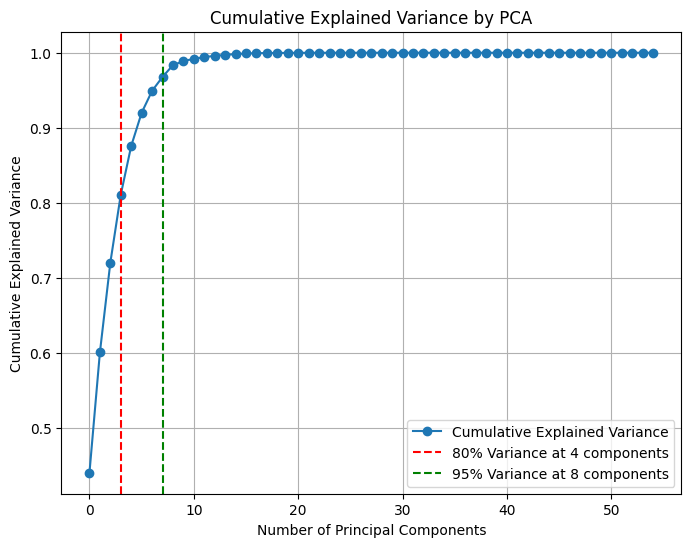

(4, 0.12362800905266129, 8, 0.07542658606318216)


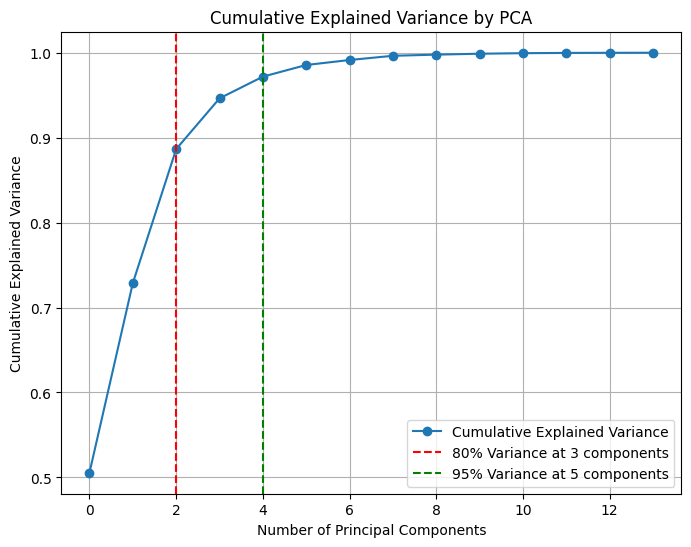

(3, 0.1904804923257541, 5, 0.11656926341168927)


In [28]:
# Function to get the PCA
def get_PCA(df, plot=False):
    # Step 1: Standardize the Data
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(df)
    
    # Step 2: Apply PCA
    pca = PCA()
    pca.fit(standardized_data)
    
    # Step 3: Explained Variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = explained_variance.cumsum()

    # Step 4: Find the number of components that explain 95% variance
    n_components_for_80_variance = np.argmax(cumulative_explained_variance >= 0.8) + 1
    
    # Step 5: Compute the slope for the first n_components_for_95_variance
    if n_components_for_80_variance > 1:
        slope_80 = (cumulative_explained_variance[n_components_for_80_variance-1] - cumulative_explained_variance[0]) / (n_components_for_80_variance - 1)
    else:
        slope_80 = cumulative_explained_variance[0]  # Only one component case

    # 95% variance
    n_components_for_95_variance = np.argmax(cumulative_explained_variance >= 0.95) + 1
    
    # Step 5: Compute the slope for the first n_components_for_95_variance
    if n_components_for_95_variance > 1:
        slope_95 = (cumulative_explained_variance[n_components_for_95_variance-1] - cumulative_explained_variance[0]) / (n_components_for_95_variance - 1)
    else:
        slope_95 = cumulative_explained_variance[0]  # Only one component case

    if plot == True:
        # Optionally plot the cumulative explained variance
        plt.figure(figsize=(8, 6))
        plt.plot(cumulative_explained_variance, marker='o', label='Cumulative Explained Variance')
        plt.axvline(x=n_components_for_80_variance-1, color='red', linestyle='--', label=f'80% Variance at {n_components_for_80_variance} components')
        plt.axvline(x=n_components_for_95_variance-1, color='green', linestyle='--', label=f'95% Variance at {n_components_for_95_variance} components')
        plt.xlabel('Number of Principal Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('Cumulative Explained Variance by PCA')
        plt.grid(True)
        plt.legend()
        plt.show()

    return n_components_for_80_variance, slope_80, n_components_for_95_variance, slope_95

# Calculate on sample
PCAcolls_all = ['pelvis_tilt', 'pelvis_list', 'pelvis_rotation', 'pelvis_tx',
       'pelvis_ty', 'pelvis_tz', 'hip_flexion_r', 'hip_adduction_r',
       'hip_rotation_r', 'knee_angle_r', 'knee_angle_r_beta', 'ankle_angle_r',
       'subtalar_angle_r', 'hip_flexion_l', 'hip_adduction_l',
       'hip_rotation_l', 'knee_angle_l', 'knee_angle_l_beta', 'ankle_angle_l',
       'subtalar_angle_l', 'L5_S1_Flex_Ext', 'L5_S1_Lat_Bending',
       'L5_S1_axial_rotation', 'L4_L5_Flex_Ext', 'L4_L5_Lat_Bending',
       'L4_L5_axial_rotation', 'L3_L4_Flex_Ext', 'L3_L4_Lat_Bending',
       'L3_L4_axial_rotation', 'L2_L3_Flex_Ext', 'L2_L3_Lat_Bending',
       'L2_L3_axial_rotation', 'L1_L2_Flex_Ext', 'L1_L2_Lat_Bending',
       'L1_L2_axial_rotation', 'L1_T12_Flex_Ext', 'L1_T12_Lat_Bending',
       'L1_T12_axial_rotation', 'neck_flexion', 'neck_bending',
       'neck_rotation', 'arm_flex_r', 'arm_add_r', 'arm_rot_r', 'elbow_flex_r',
       'pro_sup_r', 'wrist_flex_r', 'wrist_dev_r', 'arm_flex_l', 'arm_add_l',
       'arm_rot_l', 'elbow_flex_l', 'pro_sup_l', 'wrist_flex_l',
       'wrist_dev_l']

PCAcolls_arm = ['arm_flex_r', 'arm_add_r', 'arm_rot_r', 'elbow_flex_r', 'pro_sup_r',
       'wrist_flex_r', 'wrist_dev_r', 'arm_flex_l', 'arm_add_l', 'arm_rot_l',
       'elbow_flex_l', 'pro_sup_l', 'wrist_flex_l', 'wrist_dev_l']

# Calculate PCA for all
subdf = df[df["movement_in_trial"] == "movement"]
PCA_all = get_PCA(subdf[PCAcolls_all], plot=True)
print(PCA_all)

# Calculate PCA for arms
subdf = df[df["arms_mov"] == "movement"]
PCA_arms = get_PCA(subdf[PCAcolls_arm], plot=True)
print(PCA_arms)


## Min-max normalization to get to relative effort

People can be expected to have a different range of effort, depending on factors including their bodily but also cognitive predispositions. To account for this, we will normalize all timeseries to the range of observed minimum and maximum of a given participant through out the whole experiment (including part 1 that is otherwise of no interest in this particular study, see XXX). For that, we will now collect the min and max values of each timeseries for each participant.

FLAGGED: Should I normalize in the beginning the whole timeseries, or after the feature towards the timeseries max-min? Now I opt for the first one 

In [33]:
# Loop through all files and get maximum and minimum of all timeseries
minmax_dict = {}

for file in filestotrack:   # Note that now we loop over all files available (including part 1, plus practice trials)
    df = pd.read_csv(file)

    # TrialID
    TrialID = df['TrialID'][0]
    # unique participant ID
    pcnID = TrialID.split('_')[0] + '_' + TrialID.split('_')[-1]

    # Keep only numeric columns
    df_num = df.select_dtypes(include=[np.number])

    # Get the max and min of all columns
    for col in df_num.columns:
        if col != 'time':
            max_val = df_num[col].max()
            min_val = df_num[col].min()
            # Append to dictionary along the existing values of pcnID and the column
            if pcnID + '_' + col in minmax_dict:
                minmax_dict[pcnID + '_' + col].append([max_val, min_val])
            else:
                minmax_dict[pcnID + '_' + col] = [[max_val, min_val]]


# Now in the dictionary, for each key, get the max of maxs and min of mins
minmax_dict_final = {}
for key, value in minmax_dict.items():
    maxmax = max([x[0] for x in value])
    minmin = min([x[1] for x in value])
    minmax_dict_final[key] = [maxmax, minmin]

C:\Users\kadava\AppData\Local\Temp\ipykernel_3900\1428474640.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + '_norm'] = normalize_column(df, col, min, max)
C:\Users\kadava\AppData\Local\Temp\ipykernel_3900\1428474640.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + '_norm'] = normalize_column(df, col, min, max)
C:\Users\kadava\AppData\Local\Temp\ipykernel_3900\1428474640.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

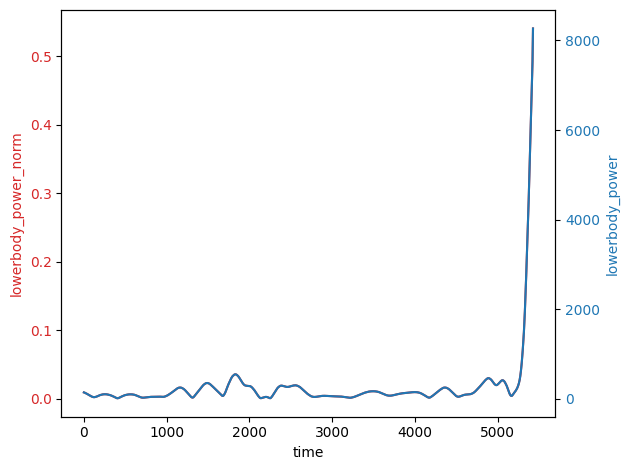

In [34]:
# Function for min-max normalization
def normalize_column(data, col_name, min_val, max_val):
    
    return (data[col_name] - min_val) / (max_val - min_val)

# Normalize sample
df = pd.read_csv(sample)
numcols = df.select_dtypes(include=[np.number]).columns # normalize only numerical columns (except time)
numcols = [x for x in numcols if x != 'time']

trialID = df['TrialID'][0]
pcnID = trialID.split('_')[0] + '_' + trialID.split('_')[-1]

# Normalize each column
for col in numcols:
    max = minmax_dict_final[pcnID + '_' + col][0]
    min = minmax_dict_final[pcnID + '_' + col][1]
    df[col + '_norm'] = normalize_column(df, col, min, max)


                
# Plot both normalized and non-normalized lowerbody power
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('lowerbody_power_norm', color=color)
ax1.plot(df['time'], df['lowerbody_power_norm'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('lowerbody_power', color=color)  # we already handled the x-label with ax1
ax2.plot(df['time'], df['lowerbody_power'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Extracting features for all trials

Now we will loop through each file (representing a trial), extract the features, add all necessary metadata and save each trial in a overall dataframe. Before any feature is collected, we min-max normalize all data to get to relative feature of effort per participant

(Notes: integral of speed is distance, integral of power is work)

In [35]:
# Function to get multimodal synchrony
def get_multimodalsync(row, ac_col, movpeak_time):
    ac_peaks = row[ac_col][0]
    # Loop over acoustic peaks and get the acoustic-movement synchrony time for each
    closeness = []
    for peak in ac_peaks:
            close = abs(peak - movpeak_time)
            #print(close)
            closeness.append(close)
            #print(closeness)
    # Get the index of the closest peak
    closest_ind = closeness.index(builtins.min(closeness)) # refering directly from builtins otherwise it interfere with something else and throws error
    # Get the time of the closest peak
    closest_time = ac_peaks[closest_ind]
    # Get the time difference
    sync = closest_time - movpeak_time

    return sync

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Initialize the dataframe
features_df = pd.DataFrame()

##########################
##### preparations #######
##########################

# These are the names of the columns with movement annotations
movcols = ['upper_mov', 'arms_mov', 'lower_mov', 'head_mov']

# These are our four dimensions for which we have aggregated movement data
groups = ['arm', 'lowerbody', 'leg', 'head']

# Mapping between dimension and annotation column
movcol_keys = {'arm': 'arms_mov', 'lowerbody': 'lower_mov', 'leg': 'lower_mov', 'head': 'head_mov', 'upperbody': 'upper_mov'}

# These are groups for BBMV
kp_arms = ['RWrist', 'RElbow', 'RShoulder', 'LWrist', 'LElbow', 'LShoulder']
kp_lower = ['RAnkle', 'RKnee', 'LAnkle', 'LKnee']
kp_legs = ['RAnkle', 'RKnee', 'LAnkle', 'LKnee']
kp_head = ['Head']
kp_keys = {'arm': kp_arms, 'lowerbody': kp_lower, 'leg': kp_legs, 'head': kp_head}

# These are cols associated with balance
balancecols = ['COPc', 'spine_moment_sum', 'pelvis_moment_sum', 'spine_moment_sum_change', 'pelvis_moment_sum_change']

# These are cols associated with acoustics
voccols = ['envelope', 'envelope_change', 'f0', 'f1_clean', 'f1_clean_vel', 'f2_clean', 'f2_clean_vel', 'f3_clean', 'f3_clean_vel', 'loudness', 'novelty', 'roughness', 'flux']

PCAcolls_all = ['pelvis_tilt', 'pelvis_list', 'pelvis_rotation', 'pelvis_tx',
       'pelvis_ty', 'pelvis_tz', 'hip_flexion_r', 'hip_adduction_r',
       'hip_rotation_r', 'knee_angle_r', 'knee_angle_r_beta', 'ankle_angle_r',
       'subtalar_angle_r', 'hip_flexion_l', 'hip_adduction_l',
       'hip_rotation_l', 'knee_angle_l', 'knee_angle_l_beta', 'ankle_angle_l',
       'subtalar_angle_l', 'L5_S1_Flex_Ext', 'L5_S1_Lat_Bending',
       'L5_S1_axial_rotation', 'L4_L5_Flex_Ext', 'L4_L5_Lat_Bending',
       'L4_L5_axial_rotation', 'L3_L4_Flex_Ext', 'L3_L4_Lat_Bending',
       'L3_L4_axial_rotation', 'L2_L3_Flex_Ext', 'L2_L3_Lat_Bending',
       'L2_L3_axial_rotation', 'L1_L2_Flex_Ext', 'L1_L2_Lat_Bending',
       'L1_L2_axial_rotation', 'L1_T12_Flex_Ext', 'L1_T12_Lat_Bending',
       'L1_T12_axial_rotation', 'neck_flexion', 'neck_bending',
       'neck_rotation', 'arm_flex_r', 'arm_add_r', 'arm_rot_r', 'elbow_flex_r',
       'pro_sup_r', 'wrist_flex_r', 'wrist_dev_r', 'arm_flex_l', 'arm_add_l',
       'arm_rot_l', 'elbow_flex_l', 'pro_sup_l', 'wrist_flex_l',
       'wrist_dev_l']

PCAcolls_arm = ['arm_flex_r', 'arm_add_r', 'arm_rot_r', 'elbow_flex_r', 'pro_sup_r',
       'wrist_flex_r', 'wrist_dev_r', 'arm_flex_l', 'arm_add_l', 'arm_rot_l',
       'elbow_flex_l', 'pro_sup_l', 'wrist_flex_l', 'wrist_dev_l']


##########################
####### main loop ########
##########################

for file in files_part2:
    print('working on file: ', file)
    df = pd.read_csv(file)

    # Get metadata
    df["concept"] = df["FileInfo"].apply(lambda x: x.split("_")[1])
    df["modality"] = df["FileInfo"].apply(lambda x: x.split("_")[2])
    df["correction"] = df["FileInfo"].apply(lambda x: x.split("_")[3])
    df.drop(columns=["FileInfo"], inplace=True)

    ######################################
    ####### min-max normalization ########
    ######################################
    
    # Get all numerical cols
    numcols = df.select_dtypes(include=[np.number]).columns
    numcols = [x for x in numcols if x != 'time']           # not time

    trialID = df['TrialID'][0]
    pcnID = trialID.split('_')[0] + '_' + trialID.split('_')[-1]

    normalized_cols = {}

    for col in numcols:
        max = minmax_dict_final[pcnID + '_' + col][0]
        min = minmax_dict_final[pcnID + '_' + col][1]
        normalized_cols[col] = normalize_column(df, col, min, max)

    df_normed = pd.DataFrame(normalized_cols)

    # get all cols that are in df but not numcols
    nonnumcols = [x for x in df.columns if x not in numcols]

    # add them to the normalized df
    for col in nonnumcols:
        df_normed[col] = df[col]

    ##########################
    ##### movement feat ######
    ##########################

    # Look only into portion of the data where is movement
    subdf = df_normed[df_normed["movement_in_trial"] == "movement"]

    if subdf.shape[0] > 0:
        duration_mov = subdf["time"].iloc[-1] - subdf["time"].iloc[0] # duration
        submovcols = [col for col in movcols if subdf[col].values[0] == "movement"]
        numofArt = len(submovcols)  # number of articulators

        # Prepare dictionary to store the values
        body_sumfeat = {}

        # Loop over our four dimensions-groups and collect features
        for group in groups:
            subsubdf = subdf[subdf[movcol_keys[group]] == "movement"]

            # If there is no movement, we set lal values to 0 and continue
            if subsubdf.shape[0] == 0:
                body_sumfeat_row = pd.DataFrame()
                body_sumfeat_row["duration_group"] = 0
                continue
            else:
                # Get the columns that contain group and sum/power (these are cols with aggregated measures)
                cols = [col for col in subsubdf.columns if group in col and 'sum' in col or 'power' in col]
                duration_group = subsubdf["time"].iloc[-1] - subsubdf["time"].iloc[0] # duration
            
                # Get statistics
                body_sumfeat = get_statistics(cols, df, subsubdf, body_sumfeat, duration_group)
                body_sumfeat[group + "_duration"] = duration_group
    
                # Calculate intermittency for kinematic measures (from Pose2sim)
                speed = subsubdf[group + "_speedKin_sum"].values
                jerk = subsubdf[group + "_jerkKin_sum"].values
                intermittency = get_intermittency(jerk, speed)
                intermittency = np.log(intermittency) # natural log
                body_sumfeat[group + "_inter_Kin"] = intermittency

                # Calculate intermittency for inverse kinematic measures (from OpenSim)
                speed = subsubdf[group + "_angSpeed_sum"].values
                jerk = subsubdf[group + "_angJerk_sum"].values
                intermittency = get_intermittency(jerk, speed)
                intermittency = np.log(intermittency) # natural log
                body_sumfeat[group + "_inter_IK"] = intermittency
                
                # Get bounding box of movement volume (BBMV)
                bbmv_sum = get_bbmv(subsubdf, group, kp_keys)           # FLAGGED: for some reason BBMV is negative, why????
                body_sumfeat[group + "_bbmv"] = bbmv_sum

                # Get rate of BBMV
                rate = bbmv_sum / duration_group
                body_sumfeat[group + "_bbmv_rate"] = rate
            
    else:
        duration_mov = 0
        numofArt = 0
        body_sumfeat = {}

    # Convert dictionary to dataframe
    body_sumfeat_row = pd.DataFrame({key: [value] for key, value in body_sumfeat.items()})

    # Adapt
    body_sumfeat_row = adapt_row(body_sumfeat_row)

    # Add duration and numofArt
    body_sumfeat_row['duration_mov'] = duration_mov
    body_sumfeat_row['numofArt'] = numofArt

    # Get BBMV for the whole body (so concatenate all the groups)
    bbmv_total = body_sumfeat_row[[col for col in body_sumfeat_row.columns if 'bbmv' in col and 'rate' not in col]].sum(axis=1)
    body_sumfeat_row['bbmv_total'] = bbmv_total
    # Total BBMV rate
    bbmv_rate = bbmv_total / duration_mov
    body_sumfeat_row['bbmv_rate'] = bbmv_rate

    ####################
    ###### balance #####
    ####################

    subdf = df_normed[df_normed["movement_in_trial"] == "movement"]

    # Collect features (note that here we collect features for the segment of the general movement, i.e., movement of any body part)
    balance_sumfeat = {}
    balance_sumfeat = get_statistics(balancecols, df_normed, subdf, balance_sumfeat, duration_mov)

    # Convert dictionary to dataframe
    balance_sumfeat_row = pd.DataFrame({key: [value] for key, value in balance_sumfeat.items()})

    # Adapt
    balance_sumfeat_row = adapt_row(balance_sumfeat_row)

    ####################
    #### acoustics #####
    ####################

    # Check if vocalization exists
    if "vocalization" not in df_normed.columns:
        print("No vocalization column in the dataframe")
        vocfeat_row = pd.DataFrame() # empty row
    else:
        # Collect features only for the time of vocalizing
        subdf = df_normed[df_normed["vocalization"] == "sounding"] 
        subdf = subdf.reset_index(drop=True)

        if subdf.shape[0] > 0:
            duration_voc = subdf["time"].iloc[-1] - subdf["time"].iloc[0] # duration

            # Collect features
            vocfeat_dict = {}
            vocfeat_dict = get_statistics(voccols, df_normed, subdf, vocfeat_dict, duration_voc)

        else:
            print("No vocalization in the trial")
            vocfeat_dict = {}
            duration_voc = 0

        # Convert dictionary to dataframe
        vocfeat_row = pd.DataFrame({key: [value] for key, value in vocfeat_dict.items()})

        # Adapt
        vocfeat_row = adapt_row(vocfeat_row)

        # Append duration
        vocfeat_row['duration_voc'] = duration_voc

        # If f1-f3 are not only nan, calculate the volume of the convex hull (i.e., vocal space area)
        if subdf['f1_clean'].isnull().all() and subdf['f2_clean'].isnull().all() and subdf['f3_clean'].isnull().all():
            print("No f1, f2, f3 in the dataframe")
            vocfeat_row['VSA_f1f2'] = None
            vocfeat_row['VSA_f1f2f3'] = None
        else:
            VSA2d, VSA3d = getVSA(subdf) # get VSA
            vocfeat_row['VSA_f1f2'] = VSA2d
            vocfeat_row['VSA_f1f2f3'] = VSA3d

    # Concatenate the rows for movement, balance, and acoustics
    newrow_concat = pd.concat([body_sumfeat_row, balance_sumfeat_row, vocfeat_row], axis=1)

    ###################################
    ###### multimodal synchrony #######
    ###################################

    # synchrony FLAGGED - here perhaps necessary to take wrist, not the aggregated arm
    
    # Prepare a list to store the syncs
    f0_syncs = []
    env_syncs = []

    if 'arm_accKin_sum_peak_times' not in newrow_concat.columns:
        print("No arm_accKin_sum_peak_times in the dataframe")
        syncs = None
    else:
        # Collect peaks of acceleration for arm #FLAG: possibly also IK measure, or wrist instead of aggregated arm???
        acc_peak_times = newrow_concat['arm_accKin_sum_peak_times'][0]

        if len(acc_peak_times) == 0:
            print("No peaks in arm_accKin_sum")
            syncs = None

        else:
            # Loop over the accpeaks and collect closest acoustic peak for each
            for acc_peak_time in acc_peak_times:

                # For f0 peaks, if not empty
                if 'f0_peak_times' in newrow_concat.columns and len(newrow_concat['f0_peak_times'][0]) > 0:
                    f0_sync = get_multimodalsync(newrow_concat, 'f0_peak_times', acc_peak_time)
                else:
                    print("No f0_peak_times in the dataframe")
                    f0_sync = None

                # Append
                f0_syncs.append(f0_sync)

                # For envelope peaks
                if 'envelope_peak_times' in newrow_concat.columns and len(newrow_concat['envelope_peak_times'][0]) > 0:
                    env_sync = get_multimodalsync(newrow_concat, 'envelope_peak_times', acc_peak_time)
                else:
                    print("No envelope_peak_times in the dataframe")
                    env_sync = None

                # Append
                env_syncs.append(env_sync)

    newrow_concat['armAcc_f0_sync'] = [f0_syncs]
    newrow_concat['armAcc_env_sync'] = [env_syncs]

    ###################################
    ###### arms submovements ##########
    ###################################

    # Take only the chunk where arms are moving
    subdf = df_normed[df_normed["arms_mov"] == "movement"]
    subdf = subdf.reset_index(drop=True)

    # Prepare an empty row to store the features
    newrow_arms = pd.DataFrame()

    if subdf.shape[0] == 0:
        print("No movement in arms")
        arms_submov = 0 # number of submovements   
        wrists_tempVar = 0 # temporal variability
    else:
        # Count submovements in wrist
        submovcols = [col for col in subdf.columns if "Wrist" in col and 'speed' in col]
        arms_submov = []
        wrists_tempVar = []
        for col in submovcols:
            # Calculate the number of peaks that delimit unique submovements
            peaks, _ = find_peaks(subdf[col], height=df_normed[col].mean(), distance=150)
            arms_submov.append(len(peaks))
            
            # Calculate the temporal variability of the submovements
            peak_times = df_normed.loc[peaks, "time"]
            intervals = np.diff(peak_times)
            tempVar = np.std(intervals)
            wrists_tempVar.append(tempVar)

        # arms_submov = sum(submovs)
        # wrists_tempVar = sum(tempVars)

    # Append to the row
    newrow_arms['arms_submovements'] = [arms_submov]
    newrow_arms['Wrist_tempVar'] = [wrists_tempVar]

    ###################################
    ###### Motor complexity (PCA) #####
    ###################################

    # Whole-body complexity             # FLAG: check whether to use joint angles, or joint angles velocities 
    subdf = df_normed.loc[df_normed['movement_in_trial'] == 'movement']
    if subdf.shape[0] == 0:
        body_nComp_80 = 0
        body_slope_80 = 0
        body_nComp_95 = 0
        body_slope_95 = 0
    else:
        bodydf = subdf.loc[:, PCAcolls_all]
        body_nComp_80, body_slope_80, body_nComp_95, body_slope_95 = get_PCA(bodydf)

    # Append to the row
    newrow_concat['body_nComp_80'] = body_nComp_80
    newrow_concat['body_slope_80'] = body_slope_80
    newrow_concat['body_nComp_95'] = body_nComp_95
    newrow_concat['body_slope_95'] = body_slope_95

    # Arm complexity
    subdf = df_normed.loc[df_normed['arms_mov'] == 'movement']
    if subdf.shape[0] == 0:
        arm_nComp_80 = 0
        arm_slope_80 = 0
        arm_nComp_95 = 0
        arm_slope_95 = 0
    else:
        armdf = subdf.loc[:, PCAcolls_arm]
        arm_nComp_80, arm_slope_80, arm_nComp_95, arm_slope_95 = get_PCA(armdf)

    # Append to the row
    newrow_concat['arm_nComp_80'] = arm_nComp_80
    newrow_concat['arm_slope_80'] = arm_slope_80
    newrow_concat['arm_nComp_95'] = arm_nComp_95
    newrow_concat['arm_slope_95'] = arm_slope_95


    # Concatenate newrow and newrow_arms
    newrow_final = pd.concat([newrow_concat, newrow_arms], axis=1)

    # Add metadata
    newrow_final["TrialID"] = df_normed["TrialID"].values[0]
    newrow_final["concept"] = df_normed["concept"].values[0]
    newrow_final["modality"] = df_normed["modality"].values[0]
    newrow_final["correction"] = df_normed["correction"].values[0]

    # Add the row the the overal df
    features_df = pd.concat([features_df, newrow_final], ignore_index=True)

    ###################################
    ########### Answer info ###########
    ###################################

    index = int(df_normed["TrialID"].values[0].split("_")[2])
    concept = df_normed["concept"].values[0]

    # Check what was the answer and cosine similarity for the index
    answer_fol = similaritydata[similaritydata["index"] == index]["answer"].values[0]
    answer_fol_sim = similaritydata[similaritydata["index"] == index]["cosine_similarity"].values[0]

    # Check what was the answer and cosine similarity for index before - but only if the previous index has the same concept as the current one
    if index - 1 in similaritydata["index"].values and similaritydata[similaritydata["index"] == index - 1]["word"].values[0] == concept:
        answer_prev = similaritydata[similaritydata["index"] == index - 1]["answer"].values[0]
        answer_prev_sim = similaritydata[similaritydata["index"] == index - 1]["cosine_similarity"].values[0]
    else:
        #print("previous index doesn't have the same concept")
        answer_prev = None
        answer_prev_sim = None

    # Append to the features_df
    features_df.loc[features_df["TrialID"] == df_normed["TrialID"].values[0], "answer_fol"] = answer_fol
    features_df.loc[features_df["TrialID"] == df_normed["TrialID"].values[0], "answer_fol_dist"] = answer_fol_sim
    features_df.loc[features_df["TrialID"] == df_normed["TrialID"].values[0], "answer_prev"] = answer_prev
    features_df.loc[features_df["TrialID"] == df_normed["TrialID"].values[0], "answer_prev_dist"] = answer_prev_sim

    # Check what is the expressibility for the concept & modality
    express = express_df[(express_df["word"] == concept) & (express_df["modality"] == df_normed["modality"].values[0])]["fit"].values[0]
    features_df.loc[features_df["TrialID"] == df_normed["TrialID"].values[0], "expressibility"] = express

    # Add response time from answerdata
    response_time = answerdata[answerdata["TrialID"] == df_normed["TrialID"].values[0]]["response_time_sec"].values[0]
    features_df.loc[features_df["TrialID"] == df_normed["TrialID"].values[0], "response_time_sec"] = response_time


# Create a concept id to group together corrections of one concept
for row in features_df.iterrows():
    row = row[1]
    features_df.loc[row.name, "concept_id"] = row["concept"] + "_" + row["modality"] + "_" + row["TrialID"].split("_")[-1]

# Get rid of columns that have only NA values
features_df = features_df.dropna(axis=1, how='all')

working on file:  e:\FLESH_ContinuousBodilyEffort\07_TS_featureExtraction\..\05_finalMerge\TS_final\merged_anno_0_2_23_p1.csv
No f0_peak_times in the dataframe
No f0_peak_times in the dataframe
No f0_peak_times in the dataframe
No f0_peak_times in the dataframe
working on file:  e:\FLESH_ContinuousBodilyEffort\07_TS_featureExtraction\..\05_finalMerge\TS_final\merged_anno_0_2_24_p1.csv
No f0_peak_times in the dataframe
No f0_peak_times in the dataframe
No f0_peak_times in the dataframe
No f0_peak_times in the dataframe
working on file:  e:\FLESH_ContinuousBodilyEffort\07_TS_featureExtraction\..\05_finalMerge\TS_final\merged_anno_0_2_25_p1.csv
No f0_peak_times in the dataframe
No f0_peak_times in the dataframe
No f0_peak_times in the dataframe
No f0_peak_times in the dataframe
No f0_peak_times in the dataframe
working on file:  e:\FLESH_ContinuousBodilyEffort\07_TS_featureExtraction\..\05_finalMerge\TS_final\merged_anno_0_2_26_p1.csv
No f0_peak_times in the dataframe
No f0_peak_times in 

In [37]:
features_df.head(50)

,arm_duration,arm_inter_Kin,arm_inter_IK,arm_bbmv,arm_bbmv_rate,lowerbody_duration,lowerbody_inter_Kin,lowerbody_inter_IK,lowerbody_bbmv,lowerbody_bbmv_rate,...,concept,modality,correction,answer_fol,answer_fol_dist,answer_prev,answer_prev_dist,expressibility,response_time_sec,concept_id
0,3322.0,27.356859,29.239638,-1.115358,-0.000336,2010.0,24.988678,25.930883,-2.254046,-0.001121,...,groot,combinatie,c0,verwonderen,0.165667,None,None,0.763,8.510330,groot_combinatie_p1
1,3884.0,28.089337,29.786296,-1.307286,-0.000337,2886.0,26.824224,27.588747,-1.618941,-0.000561,...,groot,combinatie,c1,hoogte,0.201708,verwonderen,0.165667,0.763,14.509408,groot_combinatie_p1
2,3896.0,27.811772,29.101671,-1.082353,-0.000278,2770.0,26.226360,28.208355,-3.023542,-0.001092,...,groot,combinatie,c2,groot,1.000000,hoogte,0.201708,0.763,5.644284,groot_combinatie_p1
3,3620.0,27.616634,29.051350,-0.741183,-0.000205,4216.0,28.135738,29.476029,-1.128610,-0.000268,...,hoog,combinatie,c0,hoogte,0.571184,None,None,0.749,11.391028,hoog_combinatie_p1
4,4594.0,27.960694,30.539507,-0.929572,-0.000202,4566.0,28.167866,28.456917,-0.988742,-0.000217,...,hoog,combinatie,c1,ruimte,0.067652,hoogte,0.571184,0.749,7.501799,hoog_combinatie_p1
5,3756.0,28.207225,30.062546,-0.634892,-0.000169,3444.0,27.177708,28.613299,-1.704444,-0.000495,...,hoog,combinatie,c2,verkijken,0.020472,ruimte,0.067652,0.749,15.112003,hoog_combinatie_p1
6,NaN,NaN,NaN,NaN,NaN,2590.0,26.638454,27.314485,-3.200467,-0.001236,...,blij,combinatie,c0,wachten,0.224411,None,None,0.797,3.951993,blij_combinatie_p1
7,5310.0,29.683837,31.095610,-1.985257,-0.000374,5194.0,29.235131,29.716510,-5.177732,-0.000997,...,vrouw,combinatie,c0,zwanger,0.265491,None,None,0.656,5.112085,vrouw_combinatie_p0
8,1806.0,26.147411,26.380439,-3.601845,-0.001994,NaN,NaN,NaN,NaN,NaN,...,blij,combinatie,c1,tevreden,0.642785,wachten,0.224411,0.797,4.604750,blij_combinatie_p1
9,1090.0,24.781726,24.951917,-4.924656,-0.004518,1790.0,25.274349,26.943512,-2.368909,-0.001323,...,blij,combinatie,c2,gelukkig,0.869467,tevreden,0.642785,0.797,2.825947,blij_combinatie_p1


Before saving it, we also want to see which trials underwent which corrections. Some trials were guessed on first try (only_c0), some after first correction (c0_c1) and some only after second correction or not at all (all_c).


In [38]:
# Identify how are which trials corrected
c0 = features_df[features_df["correction"] == "c0"]["concept_id"].unique()
c1 = features_df[features_df["correction"] == "c1"]["concept_id"].unique()
c2 = features_df[features_df["correction"] == "c2"]["concept_id"].unique()

only_c0 = [x for x in c0 if x not in c1 and x not in c2] # Guessed on first try
c0_c1 = [x for x in c0 if x in c1 and x not in c2] # Guessed on second try
all_c = [x for x in c0 if x in c1 and x in c2] # Guessed on third try or never

# Check whether we have some data that are outside of these three categories (could be that we lost some trials in the processing pipeline)
all = features_df["concept_id"].unique()
missing = [x for x in all if x not in only_c0 and x not in c0_c1 and x not in all_c]
print("Missing: ", missing) # Currently we miss no trials 

# Add column correction_info to features_df
features_df["correction_info"] = features_df["correction"]

# If the concept_id is in only_c0, then correction_info is c0_only
features_df.loc[features_df["concept_id"].isin(only_c0), "correction_info"] = "c0_only"

# Save it
features_df.to_csv(datafolder + "features_df_final.csv", index=False)


Missing:  []


We will be also dealing with some loss of the data because some features was not possible to extract. Let's see for which features it's the most of the data

In [39]:
# Which of the columns have more than 50% of missing values
missing_values = features_df.isnull().mean()
missing_values = missing_values[missing_values > 0.5]

# Print missing values completely
print(missing_values)


envelope_peak_std         0.553846
f0_Gmean                  0.738462
f0_Gstd                   0.738462
f0_peak_mean              0.953846
f0_peak_std               0.984615
f0_range                  0.738462
f0_rate                   0.738462
f1_clean_peak_mean        0.784615
f1_clean_peak_std         0.892308
f1_clean_vel_peak_mean    0.784615
f1_clean_vel_peak_std     0.892308
f2_clean_peak_mean        0.707692
f2_clean_peak_std         0.892308
f2_clean_vel_peak_mean    0.738462
f2_clean_vel_peak_std     0.861538
f3_clean_peak_mean        0.676923
f3_clean_peak_std         0.846154
f3_clean_vel_peak_mean    0.723077
f3_clean_vel_peak_std     0.861538
loudness_peak_mean        0.815385
loudness_peak_std         0.984615
novelty_peak_mean         0.800000
novelty_peak_std          0.953846
roughness_peak_mean       0.861538
dtype: float64


Because we will proceed with XGBoost per modality, we will also save the data separately for each modality.

In [40]:
# Separate data into three dfs based on modality
features_df_gesture = features_df[features_df["modality"] == "gebaren"]
features_df_combination = features_df[features_df["modality"] == "combinatie"]
features_df_vocal = features_df[features_df["modality"] == "geluiden"]

# Save them
features_df_gesture.to_csv(datafolder + "features_df_gesture.csv", index=False)
features_df_combination.to_csv(datafolder + "features_df_combination.csv", index=False)
features_df_vocal.to_csv(datafolder + "features_df_vocal.csv", index=False)

## Quick exploration: UMAP

Because we are dealing with complex dataframe consisting of 500+ features, we can first do a quick look how does the data cluster in reduced space. We will use xxxx (UMAP) to reduce the matrix to 2 dimensions and we plot it to get first insight whether the data group 1) either by modality, 2) or by correction.

In [41]:
# First clean the data so that it doesn't contain any NaN values
#features_df_clean = features_df.dropna(axis=1, how='all')

# Or alternatively, replace all NaN values with 0 - but this could be skewing the results to something that is not true
df_clean = features_df.fillna(0)

# Initialize UMAP
reducer = umap.UMAP()

# Get numeric cols
df_num = df_clean._get_numeric_data()

# Drop NAs
df_num = df_num.dropna()

# Z-score all cols
df_scaled = StandardScaler().fit_transform(df_num) # FLAG. should this be grouped by something? (modality, correction, participant)

# Fit UMAP
embedding = reducer.fit_transform(df_scaled)
embedding.shape


(65, 2)

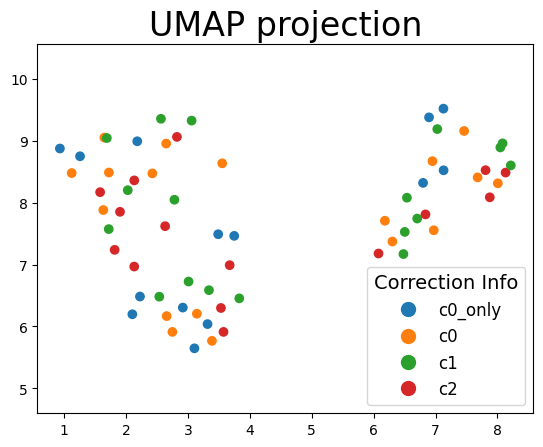

In [43]:
# Define the color mapping for correction_info
correction_info_mapping = {'c0_only': 0, "c0": 1, "c1": 2, "c2": 3}
colors = [sns.color_palette()[x] for x in correction_info_mapping.values()]

# Create the scatter plot
scatter = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in df_clean.correction_info.map(correction_info_mapping)]
)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=10, label=label) 
           for label, color in zip(correction_info_mapping.keys(), colors)]
plt.legend(handles=handles, title="Correction Info", fontsize=12, title_fontsize=14)

# Set plot aspect and title
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24)
plt.show()

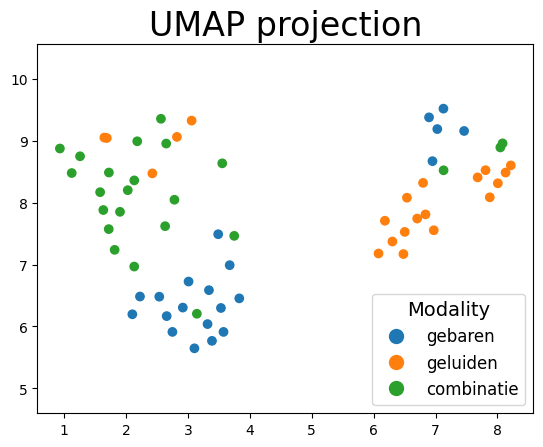

In [44]:
# Define the mapping and colors for modalities
modality_mapping = {"gebaren": 0, "geluiden": 1, "combinatie": 2}
colors = [sns.color_palette()[x] for x in modality_mapping.values()]

# Create the scatter plot
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in df_clean.modality.map(modality_mapping)]
)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=10, label=label) 
           for label, color in zip(modality_mapping.keys(), colors)]
plt.legend(handles=handles, title="Modality", fontsize=12, title_fontsize=14)

# Set plot aspect and title
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24)
plt.show()

Let's also look how the variables are correlated with each other

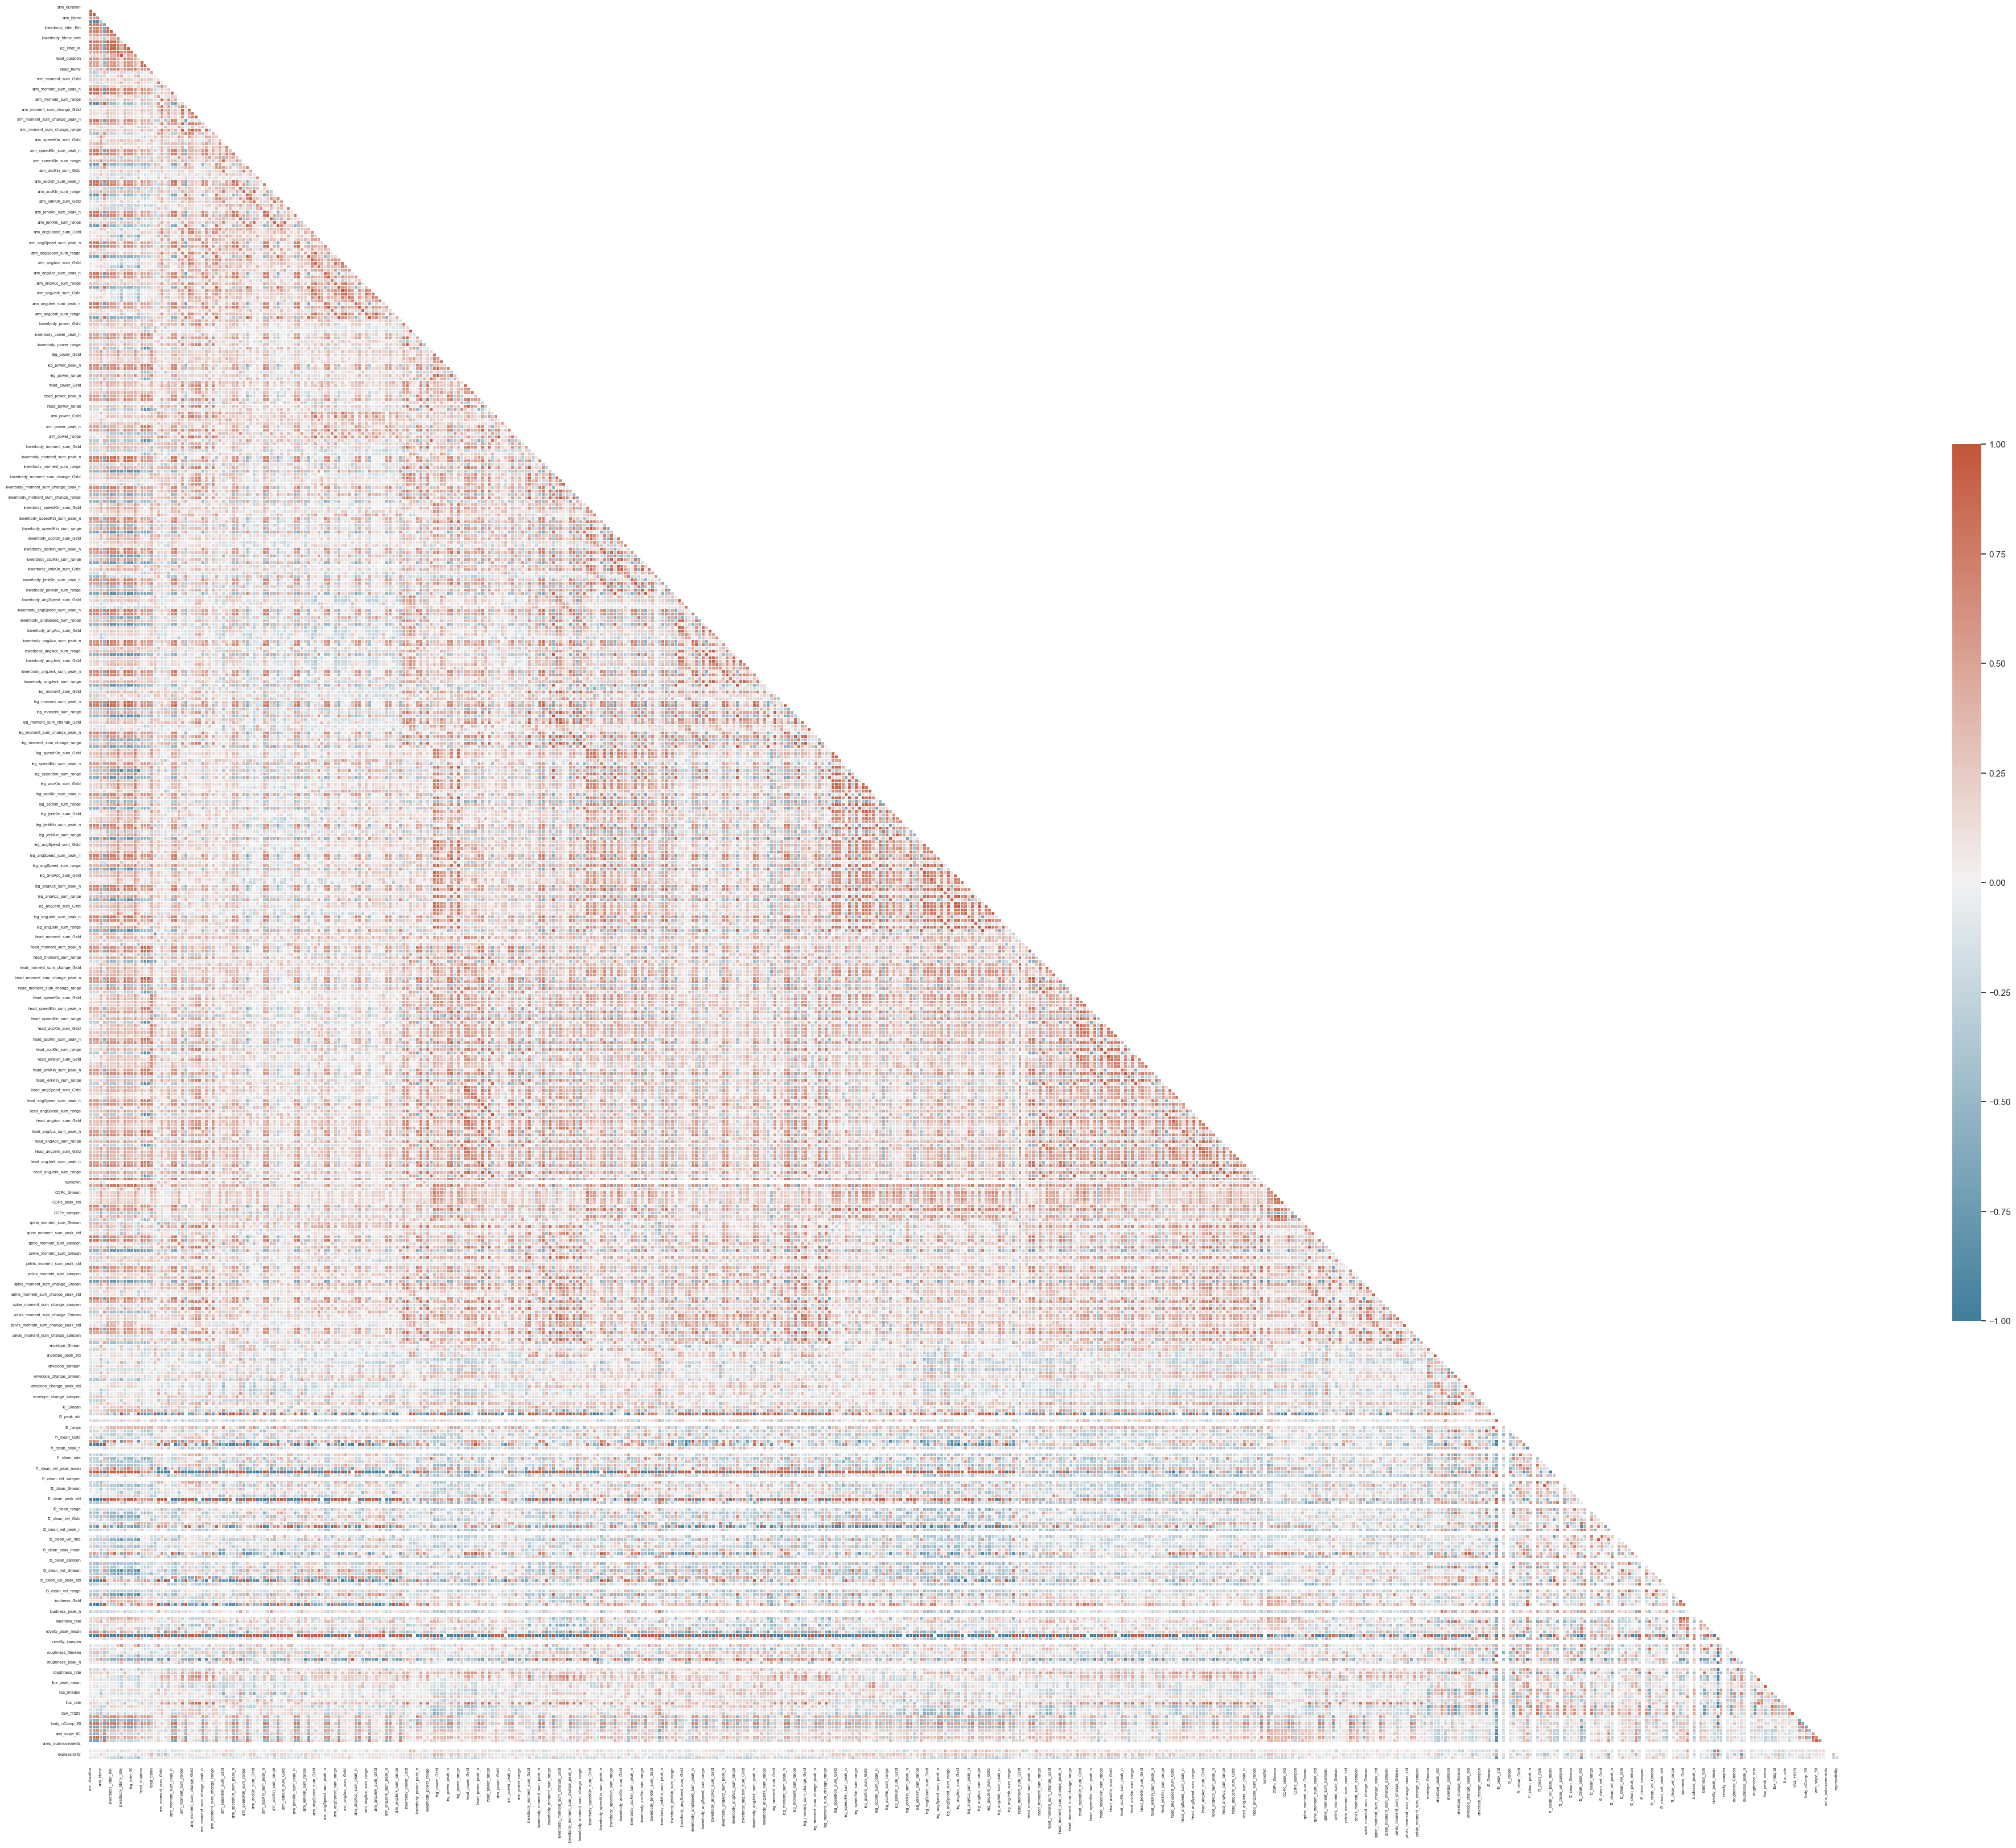

In [ ]:
sns.set_theme(style="white")

df = features_df
# Leave only numeric columns
df = df.select_dtypes(include=['float64', 'int64'])

d = df

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure with a larger size
f, ax = plt.subplots(figsize=(50,40))  # Increase the size for better readability

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5, "aspect": 30})

# Adjust the font size and rotation of the labels
plt.xticks(fontsize=5, rotation=90)  # Rotate x labels
plt.yticks(fontsize=5, rotation=0)   # y labels remain horizontal

plt.show()
